# MSPP Data Analysis Notebook

**Purpose**: Analyze mass spectrometry proteomics data from Orbitrap Astral MS (DIA-NN output)

## Notes

### Expected Results
- **HeLa**: log2 ratio ~0 (constant concentration, identical between E25 and E100)
- **E.coli**: log2 ratio ~-2 (25 fmol vs 100 fmol → log2(25/100) = -2)
- **Yeast**: log2 ratio ~+1 (150 fmol vs 75 fmol → log2(150/75) = 1)

### Sample Categorization Strategy
The notebook uses a two-tier approach to identify E25/E100 samples:
1. **Explicit Naming (Priority 1)**: Detects E25/E100/Y150/Y75 patterns in filenames
2. **E.coli Median Fallback**: If no patterns found, categorizes by E.coli median intensity
   - Lower half (lower E.coli) = E25/Y150 samples
   - Upper half (higher E.coli) = E100/Y75 samples

### Yeast Relationship
- **E25 ↔ Y150**: E25 samples are also Y150 (higher yeast spike-in)
- **E100 ↔ Y75**: E100 samples are also Y75 (lower yeast spike-in)

### Intensity Ratio Algorithm
The intensity ratio approach provides:
1. **Direct comparison** of E25 vs E100 replicates without normalization
2. **Technical variation assessment** - raw ratios preserve variability for QC
3. **Consensus proteins** - only proteins with valid intensity in BOTH samples
4. **Paired calculation** - log2(E25_intensity / E100_intensity) per protein

### Interpretation
- **HeLa ratios near 0**: Good technical reproducibility
- **E.coli ratios near -2**: Correct 4-fold spike-in maintained
- **Yeast ratios near +1**: Correct 2-fold spike-in maintained
- **Deviations from expected**: Indicate technical issues or sample preparation problems

### Workflow
- **Jupyter Notebook**: Development, validation, detailed analysis, QC checks
- **Web App**: Production tool for routine analysis with simplified interface

## 1. Import Libraries

**Required packages**:
- `pandas`: DataFrame manipulation and data analysis
- `numpy`: Numerical operations and array handling
- `matplotlib`: Plotting and visualization
- `re`: Regular expressions for pattern matching
- `pathlib`: Modern file path handling

In [8]:
import re
from pathlib import Path
from tkinter import filedialog

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Configure matplotlib
sns.set_style("darkgrid")
plt.rcParams['figure.facecolor'] = '#1e1e1e'
plt.rcParams['axes.facecolor'] = '#2d2d2d'
plt.rcParams['text.color'] = 'white'
plt.rcParams['axes.labelcolor'] = 'white'
plt.rcParams['xtick.color'] = 'white'
plt.rcParams['ytick.color'] = 'white'
plt.rcParams['legend.facecolor'] = '#2d2d2d'
plt.rcParams['legend.edgecolor'] = 'white'

print("✓ Imports complete")

✓ Imports complete


## 2. Define Organism Patterns

Set up regex patterns for identifying proteins from different organisms based on their UniProt ID format:
- **HeLa (human)**: Proteins with `_HUMAN` suffix
- **E.coli**: Proteins containing `ECOLI`
- **Yeast**: Proteins containing `YEAST`

In [9]:
# Define organism identification patterns
ORGANISMS = ["HeLa", "E.coli", "Yeast"]
ORGANISM_PATTERNS = {
    "HeLa": ["_HUMAN", "HOMO_SAPIENS"],
    "E.coli": [
        "_ECOLI", "_ECOL", "_ECO2", "_ECO5", "_ECO7",
        "_SHIF", "_SHIB", "_SHIS", "ESCHERICHIA",
    ],
    "Yeast": ["_YEAST", "SACCHAROMYCES", "CEREVISIAE"],
}

print("✓ Organism patterns defined:")
for org, patterns in ORGANISM_PATTERNS.items():
    print(f"  {org}: {'|'.join(patterns)}")


✓ Organism patterns defined:
  HeLa: _HUMAN|HOMO_SAPIENS
  E.coli: _ECOLI|_ECOL|_ECO2|_ECO5|_ECO7|_SHIF|_SHIB|_SHIS|ESCHERICHIA
  Yeast: _YEAST|SACCHAROMYCES|CEREVISIAE


## 3. File Upload

**Instructions**: 
1. Run the cell below to open a file browser
2. Select your sample TSV files (hold Ctrl/Cmd to select multiple)
3. Files will be loaded into the notebook

**Sample Identification**:
- If filenames contain E25/E100/Y150/Y75 patterns, they will be automatically recognized
- Otherwise, samples will be auto-categorized using E.coli median intensity (see Section 7)

In [10]:
from tkinter import Tk

root = Tk()
root.withdraw()
root.attributes('-topmost', True)

print("Please select your TSV files (E25 and E100 samples)...")
file_paths = filedialog.askopenfilenames(
    title='Select TSV Files (you can select multiple)',
    filetypes=[('TSV files', '*.tsv'), ('Text files', '*.txt'), ('All files', '*.*')]
)

if len(file_paths) < 2:
    raise ValueError("Please select at least 2 files")

print(f"✓ Selected {len(file_paths)} file(s):")
for fp in file_paths:
    print(f"  - {Path(fp).name}")

# Store all files for processing
all_file_paths = list(file_paths)

Please select your TSV files (E25 and E100 samples)...
✓ Selected 39 file(s):
  - report.pg_matrix_57349_E100_20_2_350960_600.tsv
  - report.pg_matrix_57351_E25_20_2_350960_800.tsv
  - report.pg_matrix_57353_E100_20_2_350960_800.tsv
  - report.pg_matrix_57354_E25_20_2_440960_600.tsv
  - report.pg_matrix_57355_E100_20_2_440960_600.tsv
  - report.pg_matrix_57356_E25_20_2_440960_800.tsv
  - report.pg_matrix_57357_E100_20_2_440960_800.tsv
  - report.pg_matrix_57358_E25_20_3_350960_600.tsv
  - report.pg_matrix_57359_E100_20_3_350960_600.tsv
  - report.pg_matrix_57360_E25_20_3_350960_800.tsv
  - report.pg_matrix_57361_E100_20_3_350960_800.tsv
  - report.pg_matrix_57362_E25_20_3_440960_600.tsv
  - report.pg_matrix_57363_E100_20_3_440960_600.tsv
  - report.pg_matrix_57364_E25_20_3_440960_800.tsv
  - report.pg_matrix_57365_E100_20_3_440960_800.tsv
  - report.pg_matrix_57366_E25_30_2_350960_600.tsv
  - report.pg_matrix_57367_E100_30_2_350960_600.tsv
  - report.pg_matrix_57368_E25_30_2_350960_800

## 4. Load and Process Data

Read all selected TSV files and prepare data for analysis:
1. Parse each file and detect intensity columns (containing `.raw` in column name)
2. Filter to keep only rows with positive intensity values
3. Identify organism for each protein based on protein name patterns
4. Concatenate all files into unified DataFrame with Source_File column

In [11]:
def identify_organism_vectorized(series):
    """Vectorized organism identification."""
    upper = series.fillna("").astype(str).str.upper()
    result = pd.Series("Unknown", index=series.index)

    for organism, patterns in ORGANISM_PATTERNS.items():
        mask = upper.str.contains("|".join(patterns), regex=True)
        result = result.where(~mask, organism)

    return pd.Categorical(result, categories=ORGANISMS)

all_data = []
file_to_raw_column = {}

# Use all selected files
files_to_load = all_file_paths if 'all_file_paths' in locals() else []

for file_path in files_to_load:
    print(f"\nLoading: {Path(file_path).name}")
    df = pd.read_csv(file_path, sep="\t", low_memory=False)
    file_stem = Path(file_path).stem

    # Find and map the .raw column
    raw_cols = [col for col in df.columns if ".raw" in col.lower()]
    if raw_cols:
        file_to_raw_column[file_stem] = raw_cols[0]
        intensity_col = raw_cols[0]
    else:
        print(f"  WARNING: No .raw columns found in {Path(file_path).name}")
        continue

    # Identify organism from protein name column
    protein_col = next(
        (col for col in ["Protein.Names", "Protein.Group"] if col in df.columns), 
        None
    ) or next((col for col in df.columns if "protein" in col.lower()), None)

    if protein_col:
        df["Organism"] = identify_organism_vectorized(df[protein_col])
    else:
        df["Organism"] = "Unknown"

    # Filter: Keep only known organisms and positive intensities
    df["Intensity"] = pd.to_numeric(df[intensity_col], errors='coerce')
    df_filtered = df[
        (df["Organism"].isin(ORGANISMS)) &
        (df["Intensity"] > 0)
    ].copy()
    
    df_filtered["Source_File"] = file_stem
    print(f"  ✓ {len(df_filtered):,} rows identified as HeLa/E.coli/Yeast")
    all_data.append(df_filtered)

if all_data:
    data = pd.concat(all_data, ignore_index=True)
    print("\n✓ Data loaded successfully")
    print(f"Total rows: {len(data):,}")
    print("Organism distribution:")
    print(data['Organism'].value_counts())
else:
    print("ERROR: No data loaded.")



Loading: report.pg_matrix_57349_E100_20_2_350960_600.tsv
  ✓ 10,969 rows identified as HeLa/E.coli/Yeast

Loading: report.pg_matrix_57351_E25_20_2_350960_800.tsv
  ✓ 10,144 rows identified as HeLa/E.coli/Yeast

Loading: report.pg_matrix_57353_E100_20_2_350960_800.tsv
  ✓ 10,829 rows identified as HeLa/E.coli/Yeast

Loading: report.pg_matrix_57354_E25_20_2_440960_600.tsv
  ✓ 10,309 rows identified as HeLa/E.coli/Yeast

Loading: report.pg_matrix_57355_E100_20_2_440960_600.tsv
  ✓ 11,124 rows identified as HeLa/E.coli/Yeast

Loading: report.pg_matrix_57356_E25_20_2_440960_800.tsv
  ✓ 10,402 rows identified as HeLa/E.coli/Yeast

Loading: report.pg_matrix_57357_E100_20_2_440960_800.tsv
  ✓ 10,943 rows identified as HeLa/E.coli/Yeast

Loading: report.pg_matrix_57358_E25_20_3_350960_600.tsv
  ✓ 10,115 rows identified as HeLa/E.coli/Yeast

Loading: report.pg_matrix_57359_E100_20_3_350960_600.tsv
  ✓ 10,697 rows identified as HeLa/E.coli/Yeast

Loading: report.pg_matrix_57360_E25_20_3_350960_8

## 5. Data Overview

Quick look at the loaded data structure and organism distribution across samples.

In [12]:
print("=" * 80)
print("DATA OVERVIEW")
print("=" * 80)
print(f"\nDataFrame shape: {data.shape}")
print("\nOrganism Distribution:")
organism_counts = data['Organism'].value_counts()
print(organism_counts)
print(f"Total: {organism_counts.sum():,}")

print("\nBy Sample:")
sample_org_counts = data.groupby(['Source_File', 'Organism']).size().unstack(fill_value=0)
display(sample_org_counts) # type: ignore

DATA OVERVIEW

DataFrame shape: (390370, 48)

Organism Distribution:
Organism
HeLa      226586
Yeast     140011
E.coli     23773
Name: count, dtype: int64
Total: 390,370

By Sample:


<positron-console-cell-12>:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


Organism,HeLa,E.coli,Yeast
Source_File,,,
report.pg_matrix_57349_E100_20_2_350960_600,6428,929,3612
report.pg_matrix_57351_E25_20_2_350960_800,5825,385,3934
report.pg_matrix_57353_E100_20_2_350960_800,6358,892,3579
report.pg_matrix_57354_E25_20_2_440960_600,5946,401,3962
report.pg_matrix_57355_E100_20_2_440960_600,6520,952,3652
report.pg_matrix_57356_E25_20_2_440960_800,5982,424,3996
report.pg_matrix_57357_E100_20_2_440960_800,6414,909,3620
report.pg_matrix_57358_E25_20_3_350960_600,5827,386,3902
report.pg_matrix_57359_E100_20_3_350960_600,6288,890,3519


## 6. Define Analysis Utilities

Define helper functions:
- `extract_mix_identifier()`: Parse filename to extract experimental run parameters
- `calculate_intensity_ratios()`: Calculate log2(E25/E100) ratios for consensus proteins present in both E25 and E100 samples

In [13]:
def extract_mix_identifier(filename):
    """Extract mix identifier from filename using suffix-based logic."""
    match = re.search(r'(?:E[-_]?(?:25|100)|Y[-_]?(?:150|75))[-_](.*)', filename, re.IGNORECASE)
    return match.group(1) if match else "Unknown"

def calculate_intensity_ratios(data, e25_file, e100_file, organism, file_to_raw_column):
    """Calculate log2(E25/E100) intensity ratios for consensus proteins"""
    if e25_file not in file_to_raw_column or e100_file not in file_to_raw_column:
        return None

    e25_intensity_col = file_to_raw_column[e25_file]
    e100_intensity_col = file_to_raw_column[e100_file]

    e25_data = data[data["Source_File"] == e25_file].copy()
    e100_data = data[data["Source_File"] == e100_file].copy()

    e25_org = e25_data[e25_data["Organism"] == organism]
    e100_org = e100_data[e100_data["Organism"] == organism]

    if len(e25_org) == 0 or len(e100_org) == 0:
        return None

    protein_col = next(
        (col for col in ["Protein.Group", "Protein.Ids", "Protein.Names"] if col in e25_org.columns),
        None
    )

    if protein_col is None:
        return None

    e25_valid = e25_org[
        (e25_org[e25_intensity_col].notna()) &
        (e25_org[e25_intensity_col] > 0)
    ]
    e100_valid = e100_org[
        (e100_org[e100_intensity_col].notna()) &
        (e100_org[e100_intensity_col] > 0)
    ]

    e25_proteins = set(e25_valid[protein_col])
    e100_proteins = set(e100_valid[protein_col])
    consensus_proteins = e25_proteins & e100_proteins

    print(f"  {organism}: E25={len(e25_proteins)}, E100={len(e100_proteins)}, consensus={len(consensus_proteins)}")

    if len(consensus_proteins) == 0:
        return None

    e25_consensus = e25_valid[e25_valid[protein_col].isin(consensus_proteins)].set_index(protein_col)
    e100_consensus = e100_valid[e100_valid[protein_col].isin(consensus_proteins)].set_index(protein_col)

    common_proteins = e25_consensus.index.intersection(e100_consensus.index)
    e25_aligned = e25_consensus.loc[common_proteins, e25_intensity_col]
    e100_aligned = e100_consensus.loc[common_proteins, e100_intensity_col]

    ratios = np.log2(e25_aligned.values / e100_aligned.values)
    valid_ratios = ratios[np.isfinite(ratios)]

    return valid_ratios if len(valid_ratios) > 0 else None

print("✓ Analysis utilities defined")


✓ Analysis utilities defined


## 7. Calculate Intensity Ratios

Identify E25/E100 pairs using hybrid categorization strategy:
1. **First**: Try to detect E25/E100/Y150/Y75 from filename patterns
2. **Fallback**: If not found, use E.coli median intensity to categorize samples
   - Lower E.coli median → E25/Y150 group
   - Higher E.coli median → E100/Y75 group

Then calculate log2 intensity ratios for each pair and organism.

In [14]:
# Get all sample files
sample_files = sorted(data["Source_File"].unique())

if len(sample_files) == 0:
    raise ValueError("No sample files found in data")

if len(sample_files) < 2:
    raise ValueError("Need at least 2 samples to create E25/E100 comparisons")

# Strategy 1: Try to detect E25/E100 from filenames (explicit naming)
e25_samples_explicit = []
e100_samples_explicit = []
unclassified_samples = []

for source_file in sample_files:
    upper = source_file.upper()
    if re.search(r'E[-_]?25|Y[-_]?150', upper):
        e25_samples_explicit.append(source_file)
    elif re.search(r'E[-_]?100|Y[-_]?75', upper):
        e100_samples_explicit.append(source_file)
    else:
        unclassified_samples.append(source_file)

# Strict pairing strategy: Match by mix parameters (suffix)
strict_pairs = []
singlets = []
strict_pairs_dict = {}

def get_mix_suffix(filename):
    match = re.search(r'(?:E[-_]?(?:25|100)|Y[-_]?(?:150|75))[-_](.*)', filename, re.IGNORECASE)
    return match.group(1) if match else None

# Group by suffix
for s in e25_samples_explicit:
    suffix = get_mix_suffix(s)
    if suffix:
        if suffix not in strict_pairs_dict: strict_pairs_dict[suffix] = {}
        if 'E25' in strict_pairs_dict[suffix]:
            singlets.append(s)
        else:
            strict_pairs_dict[suffix]['E25'] = s
    else: singlets.append(s)

for s in e100_samples_explicit:
    suffix = get_mix_suffix(s)
    if suffix:
        if suffix not in strict_pairs_dict: strict_pairs_dict[suffix] = {}
        if 'E100' in strict_pairs_dict[suffix]:
            singlets.append(s)
        else:
            strict_pairs_dict[suffix]['E100'] = s
    else: singlets.append(s)

for suffix, pair in strict_pairs_dict.items():
    if 'E25' in pair and 'E100' in pair:
        strict_pairs.append((pair['E25'], pair['E100']))
    else: singlets.extend(pair.values())

pattern_detected = len(strict_pairs) > 0 or len(singlets) > 0

# Decide pairing method
if len(strict_pairs) > 0:
    # Success: Use strict pairs, ignore singlets
    sample_pairs = sorted(strict_pairs)
    categorization_method = "explicit naming (suffix-based)"
    print(f"✓ Using strict suffix pairing: {len(sample_pairs)} pairs found. {len(singlets)} singlets ignored.")
else:
    # Fallback to Index Pairing if strict pairing failed
    if pattern_detected:
        print("⚠ Strict pairing found specific suffixes but ZERO matches. Falling back to index-based pairing (Potential Mismatch Risk).")
    else:
        print("⚠ No specific naming pattern detected. Falling back to index-based pairing.")
    
    categorization_method = "Index-based fallback"
    
    # If explicit E25/E100 lists exist but didn't match via suffix, use them
    if len(e25_samples_explicit) > 0 and len(e100_samples_explicit) > 0:
        e25_samples = sorted(e25_samples_explicit)
        e100_samples = sorted(e100_samples_explicit)
    else:
        # Last resort: E.coli median categorization (from original notebook)
        print("  ...Attempting E.coli median categorization...")
        ecoli_medians = {}
        for source_file in sample_files:
            intensity_col = file_to_raw_column.get(source_file)
            if not intensity_col: continue
            ecoli_data = data[(data["Source_File"] == source_file) & (data["Organism"] == "E.coli")]
            if len(ecoli_data) > 0:
                # Ensure intensity is numeric
                vals = pd.to_numeric(ecoli_data[intensity_col], errors='coerce')
                median_val = vals[vals > 0].median()
                if pd.notna(median_val):
                    ecoli_medians[source_file] = median_val
        
        if len(ecoli_medians) < 2:
             # Absolute last resort: just split the list in half
             e25_samples = sample_files[:len(sample_files)//2]
             e100_samples = sample_files[len(sample_files)//2:]
        else:
             sorted_samples = sorted(ecoli_medians.keys(), key=lambda x: ecoli_medians[x])
             n = len(sorted_samples)
             e25_samples = sorted_samples[:n//2]
             e100_samples = sorted_samples[n//2:]
    
    # Pair by index
    sample_pairs = []
    for i in range(min(len(e25_samples), len(e100_samples))):
        sample_pairs.append((e25_samples[i], e100_samples[i]))
    print(f"  -> Created {len(sample_pairs)} pairs by index/median.")

# Process pairs and create labels
hela_results, ecoli_results, yeast_results = [], [], []

def get_queue_pk(sample_name):
    raw_col = file_to_raw_column.get(sample_name, "")
    if raw_col:
        # raw_col might be a full path or just name. stem it.
        raw_stem = Path(raw_col).stem
        match = re.search(r'(\d+)', raw_stem)
        if match: return match.group(1)
    match = re.search(r'(\d+)', sample_name)
    return match.group(1) if match else sample_name

print(f"\nProcessing {len(sample_pairs)} sample pair(s):\n")
for e25_sample, e100_sample in sample_pairs:
    e25_id = get_queue_pk(e25_sample)
    e100_id = get_queue_pk(e100_sample)
    pair_label = f"{e25_id} vs {e100_id}"
    
    print(f"Processing pair: {pair_label}")
    for organism in ORGANISMS:
        ratios = calculate_intensity_ratios(data, e25_sample, e100_sample, organism, file_to_raw_column)
        if ratios is not None:
            if organism == "HeLa": hela_results.append((ratios, pair_label))
            elif organism == "E.coli": ecoli_results.append((ratios, pair_label))
            elif organism == "Yeast": yeast_results.append((ratios, pair_label))

print(f"\n✓ Calculated ratios for {len(hela_results)} HeLa, {len(ecoli_results)} E.coli, {len(yeast_results)} Yeast results")


✓ Using strict suffix pairing: 19 pairs found. 1 singlets ignored.

Processing 19 sample pair(s):

Processing pair: 57351 vs 57353
  HeLa: E25=5825, E100=6358, consensus=5597
  E.coli: E25=385, E100=892, consensus=376
  Yeast: E25=3934, E100=3579, consensus=3520
Processing pair: 57354 vs 57355
  HeLa: E25=5946, E100=6520, consensus=5719
  E.coli: E25=401, E100=952, consensus=387
  Yeast: E25=3962, E100=3652, consensus=3589
Processing pair: 57356 vs 57357
  HeLa: E25=5982, E100=6414, consensus=5730
  E.coli: E25=424, E100=909, consensus=412
  Yeast: E25=3996, E100=3620, consensus=3563
Processing pair: 57358 vs 57359
  HeLa: E25=5827, E100=6288, consensus=5577
  E.coli: E25=386, E100=890, consensus=373
  Yeast: E25=3902, E100=3519, consensus=3454
Processing pair: 57360 vs 57361
  HeLa: E25=5602, E100=6059, consensus=5367
  E.coli: E25=357, E100=822, consensus=348
  Yeast: E25=3863, E100=3427, consensus=3368
Processing pair: 57362 vs 57363
  HeLa: E25=5629, E100=6145, consensus=5420
  E.c

## 8. Protein Count Bar Chart

Create stacked bar chart showing organism composition across samples.

Protein ID Counts by Sample:
Organism                                     HeLa  E.coli  Yeast
Source_File                                                     
report.pg_matrix_57349_E100_20_2_350960_600  6428     929   3612
report.pg_matrix_57351_E25_20_2_350960_800   5825     385   3934
report.pg_matrix_57353_E100_20_2_350960_800  6358     892   3579
report.pg_matrix_57354_E25_20_2_440960_600   5946     401   3962
report.pg_matrix_57355_E100_20_2_440960_600  6520     952   3652
report.pg_matrix_57356_E25_20_2_440960_800   5982     424   3996
report.pg_matrix_57357_E100_20_2_440960_800  6414     909   3620
report.pg_matrix_57358_E25_20_3_350960_600   5827     386   3902
report.pg_matrix_57359_E100_20_3_350960_600  6288     890   3519
report.pg_matrix_57360_E25_20_3_350960_800   5602     357   3863
report.pg_matrix_57361_E100_20_3_350960_800  6059     822   3427
report.pg_matrix_57362_E25_20_3_440960_600   5629     361   3853
report.pg_matrix_57363_E100_20_3_440960_600  6145     853   3

<positron-console-cell-15>:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


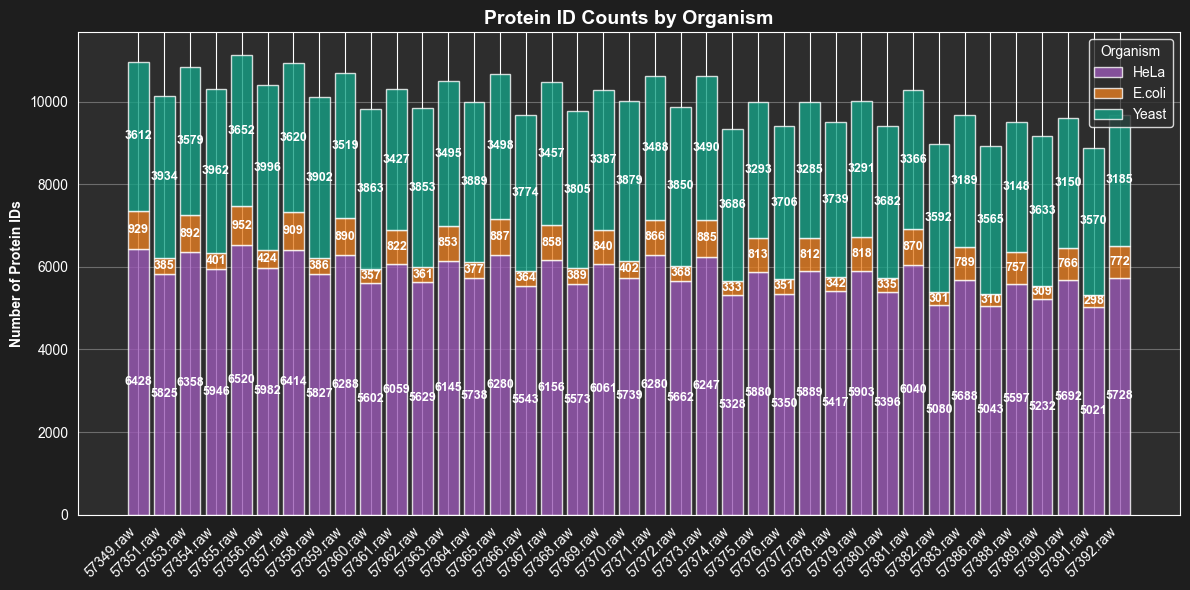

In [15]:
counts = data.groupby(["Source_File", "Organism"]).size().unstack(fill_value=0)
counts = counts.reindex(columns=ORGANISMS, fill_value=0)

print("Protein ID Counts by Sample:")
print(counts)
print()

# Sort samples by numeric value extracted from .raw filename
def get_numeric_sort_value(sample_name):
    raw_col = file_to_raw_column.get(sample_name, sample_name)
    raw_filename = Path(raw_col).stem
    match = re.search(r'(\d+)', raw_filename)
    return int(match.group(1)) if match else 0

sorted_samples = sorted(counts.index, key=get_numeric_sort_value)
counts = counts.reindex(sorted_samples)

fig, ax = plt.subplots(figsize=(12, 6))
bottom = np.zeros(len(counts))
COLORS = {"HeLa": "#9b59b6", "E.coli": "#e67e22", "Yeast": "#16a085"}

for organism in counts.columns:
    ax.bar(range(len(counts)), counts[organism], bottom=bottom,
           label=organism, color=COLORS.get(organism), alpha=0.8)
    bottom += counts[organism].values

for i, sample in enumerate(counts.index):
    y_off = 0
    for org in counts.columns:
        val = counts.loc[sample, org]
        if val > 0:
            ax.text(i, y_off + val/2, str(int(val)), ha='center', va='center',
                    fontsize=9, fontweight='bold', color='white')
            y_off += val

# Use .raw filenames for labels
x_labels = [Path(file_to_raw_column.get(s, s)).name for s in counts.index]
ax.set_xticks(range(len(counts)))
ax.set_xticklabels(x_labels, rotation=45, ha="right")
ax.set_ylabel("Number of Protein IDs", fontweight="bold")
ax.set_title("Protein ID Counts by Organism", fontsize=14, fontweight="bold")
ax.legend(title="Organism", loc="upper right")
ax.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()


## 9. Plotting Function for Ratio Comparison

Define function to create box plots showing log2 intensity ratio distributions for each organism and experimental run. Box plots display:
- Quartiles (box)
- Median (line inside box)
- Mean (white square marker)
- Whiskers extending to min/max values
- Individual outliers as data points

In [16]:
def plot_ratio_comparison(ax, results, title, color, reference_line):
    """Plot box plots for intensity ratios."""
    data_arrays = [r[0] for r in results]
    mix_labels = [r[1] for r in results]
    positions = np.arange(1, len(data_arrays) + 1)

    bp = ax.boxplot(data_arrays, positions=positions, widths=0.6, patch_artist=True, showfliers=True, showmeans=True,
                    flierprops={"marker": "o", "markerfacecolor": color, "markersize": 3, "alpha": 0.4, "markeredgecolor": "none"},
                    meanprops={"marker": "s", "markerfacecolor": "white", "markeredgecolor": "white", "markersize": 5})

    for patch in bp["boxes"]:
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
        patch.set_edgecolor("white")
        patch.set_linewidth(1.5)

    plt.setp(bp["whiskers"], color="white", linewidth=1.5)
    plt.setp(bp["caps"], color="white", linewidth=1.5)
    plt.setp(bp["medians"], color="#2c3e50", linewidth=2.5)

    medians = []
    for i, data_arr in enumerate(data_arrays):
        m = np.median(data_arr)
        medians.append(m)
        ax.text(i + 1, m, f"{m:.2f}", fontsize=9, va="bottom", ha="center", color="white", fontweight="bold",
                bbox={"boxstyle": "round,pad=0.3", "facecolor": "black", "alpha": 0.5, "edgecolor": "none"})

    ax.axhline(y=reference_line, color="#f39c12", linestyle="--", linewidth=2, alpha=0.9, label=f"Expected: {reference_line}")
    
    if medians:
        avg_m = np.mean(medians)
        ax.plot([], [], ' ', label=f"Mean Median: {avg_m:.2f}")

    ax.set_ylabel("Log2 Intensity Ratio", fontsize=11, fontweight="bold")
    ax.set_title(title, fontsize=12, fontweight="bold")
    ax.set_xticks(positions)
    ax.set_xticklabels(mix_labels, rotation=45, ha="right", fontsize=9)
    ax.grid(axis="y", alpha=0.3)
    ax.legend(fontsize=9, loc="upper right")

print("✓ Plotting function defined")


✓ Plotting function defined


## 10. Generate Intensity Ratio Plots

Create 3-panel stacked visualization showing log2 intensity ratios for each organism:
- **Top**: HeLa (expected ratio ≈ 0 - constant concentration)
- **Middle**: E.coli (expected ratio ≈ -2 - log2(25/100))
- **Bottom**: Yeast (expected ratio ≈ +1 - log2(150/75))

Each panel shows box plot distribution of protein ratios with individual data points shown as outliers and expected value marked with reference line.

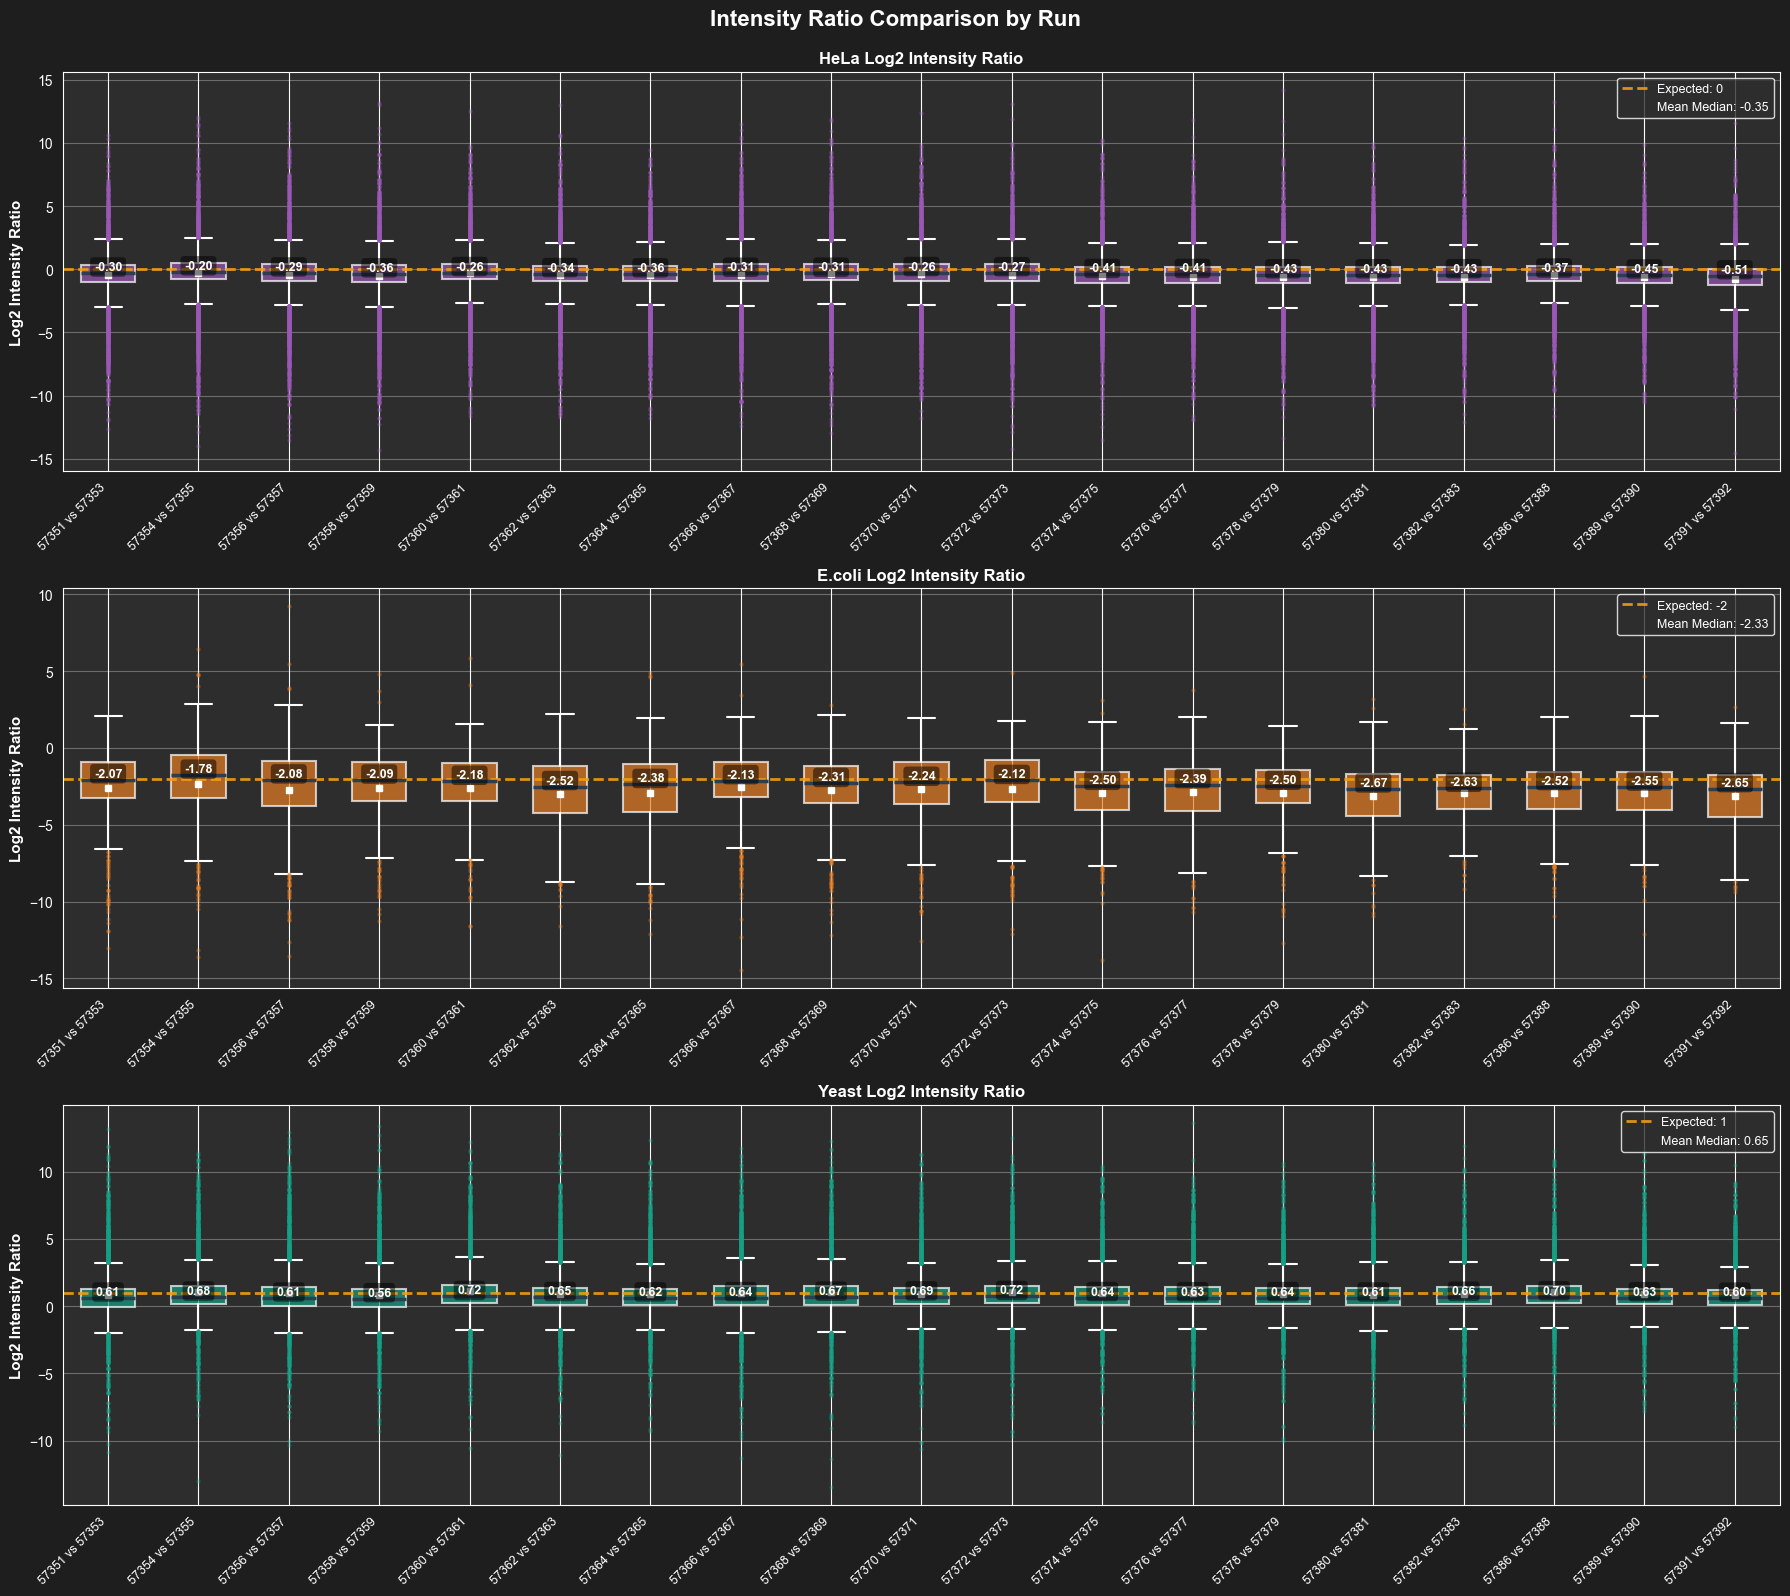


✓ Plots generated successfully


In [17]:
if hela_results or ecoli_results or yeast_results:
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(18, 16))

    if hela_results:
        plot_ratio_comparison(
            ax1, hela_results,
            title="HeLa Log2 Intensity Ratio",
            color="#9b59b6",
            reference_line=0
        )
    else:
        ax1.text(0.5, 0.5, "No HeLa data", ha="center", va="center",
                transform=ax1.transAxes, fontsize=14)
        ax1.set_ylabel("Log2 Intensity Ratio", fontsize=11, fontweight="bold")
        ax1.set_title("HeLa Log2 Intensity Ratio", fontsize=12, fontweight="bold")

    if ecoli_results:
        plot_ratio_comparison(
            ax2, ecoli_results,
            title="E.coli Log2 Intensity Ratio",
            color="#e67e22",
            reference_line=-2
        )
    else:
        ax2.text(0.5, 0.5, "No E.coli data", ha="center", va="center",
                transform=ax2.transAxes, fontsize=14)
        ax2.set_ylabel("Log2 Intensity Ratio", fontsize=11, fontweight="bold")
        ax2.set_title("E.coli Log2 Intensity Ratio", fontsize=12, fontweight="bold")

    if yeast_results:
        plot_ratio_comparison(
            ax3, yeast_results,
            title="Yeast Log2 Intensity Ratio",
            color="#16a085",
            reference_line=1
        )
    else:
        ax3.text(0.5, 0.5, "No Yeast data", ha="center", va="center",
                transform=ax3.transAxes, fontsize=14)
        ax3.set_ylabel("Log2 Intensity Ratio", fontsize=11, fontweight="bold")
        ax3.set_title("Yeast Log2 Intensity Ratio", fontsize=12, fontweight="bold")

    plt.suptitle(
        "Intensity Ratio Comparison by Run",
        fontsize=16,
        fontweight="bold",
        y=0.995
    )
    plt.tight_layout()
    plt.show()

    print("\n✓ Plots generated successfully")
else:
    print("⚠ No results to plot - check that your data contains valid E25/E100 pairs")

## 11. Statistical Summaries

Calculate and display statistical summaries (count, median, mean, std, quartiles) for each organism's intensity ratios across all experimental runs.

In [18]:
# Calculate and display statistics for all organisms
def print_stats(results, organism_name):
    if results:
        print(f"{organism_name} Statistics:")
        print("=" * 60)
        for ratios, mix_id in results:
            print(f"\n{mix_id}:")
            print(f"  Count: {len(ratios)}")
            print(f"  Median: {np.median(ratios):.3f}")
            print(f"  Mean: {np.mean(ratios):.3f}")
            print(f"  Std: {np.std(ratios):.3f}")
            print(f"  Q1-Q3: {np.percentile(ratios, 25):.3f} - {np.percentile(ratios, 75):.3f}")
    else:
        print(f"No {organism_name} results")

print_stats(hela_results, "HeLa")
print("\n")
print_stats(ecoli_results, "E.coli")
print("\n")
print_stats(yeast_results, "Yeast")

HeLa Statistics:

57351 vs 57353:
  Count: 5597
  Median: -0.295
  Mean: -0.487
  Std: 2.136
  Q1-Q3: -0.972 - 0.365

57354 vs 57355:
  Count: 5719
  Median: -0.198
  Mean: -0.315
  Std: 2.274
  Q1-Q3: -0.784 - 0.530

57356 vs 57357:
  Count: 5730
  Median: -0.286
  Mean: -0.443
  Std: 2.217
  Q1-Q3: -0.904 - 0.403

57358 vs 57359:
  Count: 5577
  Median: -0.357
  Mean: -0.566
  Std: 2.232
  Q1-Q3: -1.015 - 0.304

57360 vs 57361:
  Count: 5367
  Median: -0.256
  Mean: -0.326
  Std: 2.043
  Q1-Q3: -0.791 - 0.442

57362 vs 57363:
  Count: 5420
  Median: -0.340
  Mean: -0.465
  Std: 2.028
  Q1-Q3: -0.943 - 0.282

57364 vs 57365:
  Count: 5546
  Median: -0.356
  Mean: -0.490
  Std: 1.963
  Q1-Q3: -0.944 - 0.292

57366 vs 57367:
  Count: 5357
  Median: -0.312
  Mean: -0.413
  Std: 2.147
  Q1-Q3: -0.912 - 0.401

57368 vs 57369:
  Count: 5320
  Median: -0.309
  Mean: -0.386
  Std: 2.172
  Q1-Q3: -0.864 - 0.409

57370 vs 57371:
  Count: 5515
  Median: -0.257
  Mean: -0.391
  Std: 2.112
  Q1-Q3

## 12. Validation Report

Validate that intensity ratios match expected patterns for each organism:
- **HeLa**: Expected ≈ 0 (constant concentration), PASS if |median| < 0.5
- **E.coli**: Expected ≈ -2 (4-fold reduction), PASS if -2.5 < median < -1.5  
- **Yeast**: Expected ≈ +1 (2-fold increase), PASS if 0.5 < median < 1.5

Results indicate whether sample preparation and instrument performance meet specifications.

In [19]:
print("Validation Summary:")
print("=" * 60)

if hela_results:
    hela_medians = [np.median(r[0]) for r in hela_results]

    print("\nHeLa Expected Pattern:")
    print(f"  Median range: {min(hela_medians):.2f} to {max(hela_medians):.2f}")
    print(f"  Average median: {np.mean(hela_medians):.2f}")
    print("  Expected: ~0 (constant concentration)")
    print(f"  Status: {'✓ PASS' if abs(np.mean(hela_medians)) < 0.5 else '⚠ CHECK'}")

if ecoli_results:
    ecoli_medians = [np.median(r[0]) for r in ecoli_results]

    print("\nE.coli Expected Pattern:")
    print(f"  Median range: {min(ecoli_medians):.2f} to {max(ecoli_medians):.2f}")
    print(f"  Average median: {np.mean(ecoli_medians):.2f}")
    print("  Expected: ~-2 (log2(25/100) = -2)")
    print(f"  Status: {'✓ PASS' if -2.5 < np.mean(ecoli_medians) < -1.5 else '⚠ CHECK'}")

if yeast_results:
    yeast_medians = [np.median(r[0]) for r in yeast_results]

    print("\nYeast Expected Pattern:")
    print(f"  Median range: {min(yeast_medians):.2f} to {max(yeast_medians):.2f}")
    print(f"  Average median: {np.mean(yeast_medians):.2f}")
    print("  Expected: ~+1 (log2(150/75) = 1)")
    print(f"  Status: {'✓ PASS' if 0.5 < np.mean(yeast_medians) < 1.5 else '⚠ CHECK'}")

print("\n✓ Analysis complete!")

Validation Summary:

HeLa Expected Pattern:
  Median range: -0.51 to -0.20
  Average median: -0.35
  Expected: ~0 (constant concentration)
  Status: ✓ PASS

E.coli Expected Pattern:
  Median range: -2.67 to -1.78
  Average median: -2.33
  Expected: ~-2 (log2(25/100) = -2)
  Status: ✓ PASS

Yeast Expected Pattern:
  Median range: 0.56 to 0.72
  Average median: 0.65
  Expected: ~+1 (log2(150/75) = 1)
  Status: ✓ PASS

✓ Analysis complete!


## Summary

This notebook provides a complete workflow for analyzing mass spectrometry proteomics data from the Orbitrap Astral using DIA-NN outputs:

### Part 1: Protein Quantification Analysis
1. **Import & Configure** (Section 1): Set up libraries and plotting styles
2. **Define Patterns** (Section 2): Establish organism identification rules
3. **Load Data** (Sections 3-4): Select and process TSV files
4. **Explore Data** (Section 5): View organism distribution and data summary
5. **Define Analysis Functions** (Section 6): Set up helper functions for ratio calculations
6. **Calculate Ratios** (Section 7): Compute E25/E100 intensity ratios using hybrid categorization
   - First tries explicit naming (E25/E100/Y150/Y75 patterns)
   - Falls back to E.coli median-based auto-categorization if needed
7. **Visualize** (Sections 8-10): Create protein counts and ratio distribution plots
8. **Analyze Statistics** (Section 11): Display median, mean, and quartile summaries
9. **Validate Results** (Section 12): Check if ratios match expected biological patterns

### Part 2: TIC Analysis (Optional)
10. **TIC Setup** (Section 13.1): Import pyteomics for mzML processing
11. **Load mzML Files** (Section 13.2): Select raw MS data files
12. **Extract TIC** (Section 13.3): Parse mzML and extract Total Ion Current
13. **Visualize TIC** (Section 13.4): Compare TIC traces across samples

**Expected Outcomes**: 
- Protein ratios should match theoretical predictions (HeLa≈0, E.coli≈-2, Yeast≈+1)
- TIC traces should show consistent peak shapes and intensities
- Results confirm proper sample preparation and instrument performance

**New Features**:
- **Smart Sample Categorization**: Automatic E25/E100 detection via E.coli median when filenames lack explicit patterns
- **Yeast Relationship Tracking**: Recognizes E25↔Y150 and E100↔Y75 equivalence
- **TIC Analysis**: Complementary QC using raw MS data (mzML files)

## 13. TIC Analysis (Optional)

**Total Ion Current (TIC)** analysis provides a complementary view of sample quality and instrument performance by visualizing the sum of all ion intensities across the chromatographic run.

**When to use TIC analysis:**
- Quality control of raw MS data before protein identification
- Detecting instrument drift or performance issues
- Comparing chromatographic reproducibility across runs
- Identifying sample loading or elution problems

**Note**: This section requires mzML files (raw MS data), which are separate from the TSV protein quantification files used above.

### 13.1 Import TIC Dependencies

Additional libraries needed for mzML processing:
- `pyteomics`: Proteomics data parsing library
- `lxml`: XML parsing (dependency for pyteomics)

In [20]:
try:
    from pyteomics import mzml
    print("✓ pyteomics imported successfully")
except ImportError:
    print("⚠ pyteomics not found. Installing required packages...")
    import subprocess
    import sys
    subprocess.check_call([sys.executable, "-m", "pip", "install", "pyteomics", "lxml"])
    from pyteomics import mzml
    print("✓ pyteomics installed and imported")

✓ pyteomics imported successfully


### 13.2 Select mzML Files

Choose your mzML files for TIC analysis. These are the raw mass spectrometry data files, typically larger than the processed TSV files.

In [21]:
root = Tk()
root.withdraw()
root.attributes('-topmost', True)

print("Please select your mzML files for TIC analysis...")
mzml_file_paths = filedialog.askopenfilenames(
    title='Select mzML Files (you can select multiple)',
    filetypes=[('mzML files', '*.mzML'), ('All files', '*.*')]
)

if len(mzml_file_paths) == 0:
    print("⚠ No mzML files selected. Skipping TIC analysis.")
    mzml_file_paths = []
else:
    print(f"✓ Selected {len(mzml_file_paths)} mzML file(s):")
    for fp in mzml_file_paths:
        print(f"  - {Path(fp).name}")

Please select your mzML files for TIC analysis...
✓ Selected 2 mzML file(s):
  - HYE_E25_base_20251114160714_Q1.mzML
  - HYE_E25_base_20251114160714_Q2.mzML


### 13.3 Extract TIC Data

Parse mzML files and extract Total Ion Current for each scan. 

**Processing notes:**
- DIA data: Processes all scans (no MS level filtering required)
- DDA data: Would filter for MS1 scans only
- Retention time: Auto-converts from seconds to minutes if needed
- This step may take 1-2 minutes per file depending on file size

In [22]:
def extract_tic_from_mzml(file_path):
    """Extract Total Ion Current (TIC) from an mzML file.

    For DIA data, processes all scans regardless of MS level.

    Args:
        file_path: Path to the mzML file

    Returns:
        pd.DataFrame with columns: scan_number, retention_time, tic
    """
    tic_data = []

    try:
        # Open mzML file and iterate through scans
        with mzml.read(file_path) as reader:
            for scan in reader:
                scan_number = scan.get('index', 0) + 1

                # Get retention time (in minutes or seconds)
                rt = scan.get('scanList', {}).get('scan', [{}])[0].get('scan start time', 0)

                # Calculate TIC from intensity array
                intensities = scan.get('intensity array', np.array([]))
                tic = np.sum(intensities) if len(intensities) > 0 else 0

                tic_data.append({
                    'scan_number': scan_number,
                    'retention_time': rt,
                    'tic': tic
                })

        if len(tic_data) == 0:
            print(f"  ⚠ No scans found in {Path(file_path).name}")
            return None

        df = pd.DataFrame(tic_data)

        # Auto-detect RT units and convert to minutes if needed
        max_rt = df['retention_time'].max()
        if max_rt > 500:  # Likely in seconds
            df['retention_time'] = df['retention_time'] / 60.0
            print(f"  ✓ Converted RT from seconds to minutes (max RT: {max_rt/60:.2f} min)")

        if df['retention_time'].max() > 600:
            print(f"  ⚠ Warning: Max RT is {df['retention_time'].max():.2f} minutes - seems unusually high")

        print(f"  ✓ Extracted {len(df)} scans, RT range: {df['retention_time'].min():.2f}-{df['retention_time'].max():.2f} min")
        return df

    except Exception as e:
        print(f"  ✗ Error processing {Path(file_path).name}: {e}")
        return None


# Extract TIC from all selected mzML files
tic_dict = {}

if len(mzml_file_paths) > 0:
    print("Extracting TIC data from mzML files...\n")
    for mzml_path in mzml_file_paths:
        sample_name = Path(mzml_path).stem
        print(f"Processing: {sample_name}")
        tic_df = extract_tic_from_mzml(mzml_path)
        if tic_df is not None:
            tic_dict[sample_name] = tic_df

    print(f"\n✓ Successfully extracted TIC from {len(tic_dict)}/{len(mzml_file_paths)} file(s)")
else:
    print("No mzML files to process")

Extracting TIC data from mzML files...

Processing: HYE_E25_base_20251114160714_Q1
  ✓ Converted RT from seconds to minutes (max RT: 28.11 min)
  ✓ Extracted 19693 scans, RT range: 6.80-28.11 min
Processing: HYE_E25_base_20251114160714_Q2
  ✓ Converted RT from seconds to minutes (max RT: 28.18 min)
  ✓ Extracted 29780 scans, RT range: 6.54-28.18 min

✓ Successfully extracted TIC from 2/2 file(s)


### 13.4 Generate TIC Comparison Plot

Visualize TIC across retention time for all samples. The plot shows:
- **X-axis**: Retention time (minutes)
- **Y-axis**: Total Ion Current (sum of all ion intensities)
- **Lines**: One trace per sample file

**What to look for:**
- Consistent peak shapes indicate good reproducibility
- Similar total intensities suggest consistent sample loading
- Unusual dips or spikes may indicate instrument issues

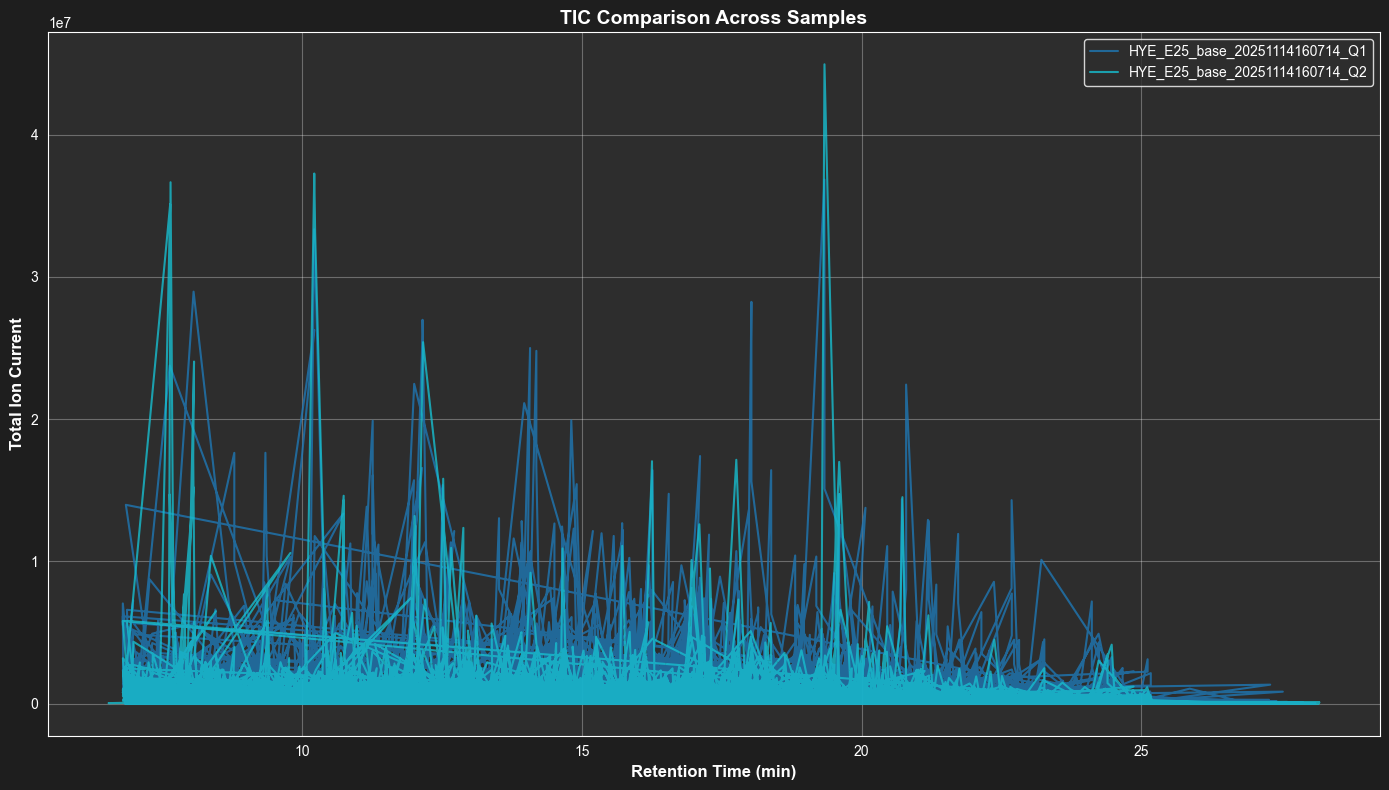


✓ TIC plot generated successfully


In [23]:
if len(tic_dict) > 0:
    fig, ax = plt.subplots(figsize=(14, 8))

    # Color palette for different samples
    colors = plt.colormaps['tab10'](np.linspace(0, 1, len(tic_dict)))

    for (sample_name, tic_df), color in zip(tic_dict.items(), colors, strict=True):
        if tic_df is not None and len(tic_df) > 0:
            ax.plot(
                tic_df['retention_time'],
                tic_df['tic'],
                label=sample_name,
                color=color,
                linewidth=1.5,
                alpha=0.8
            )

    ax.set_xlabel('Retention Time (min)', fontsize=12, fontweight='bold')
    ax.set_ylabel('Total Ion Current', fontsize=12, fontweight='bold')
    ax.set_title('TIC Comparison Across Samples', fontsize=14, fontweight='bold')
    ax.legend(fontsize=10, loc='best')
    ax.grid(True, alpha=0.3)
    ax.ticklabel_format(style='scientific', axis='y', scilimits=(0, 0))
    plt.tight_layout()
    plt.show()

    print("\n✓ TIC plot generated successfully")
else:
    print("⚠ No TIC data to plot. Run the previous cells to extract TIC data.")